<a href="https://colab.research.google.com/github/ko4ro/paper_survey_colab/blob/main/cyclegan_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**本notebookは以下のリンクで解説されているチュートリアルをもとに、日本語にしたものです。**
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で実行</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">	Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>
</td>
</table>

このノートブックでは、「[Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)」で説明されているように、条件付き GAN （敵対的生成ネットワーク）を使用してペアになっていない画像から画像への変換を実演します。サイクル構造の敵対的ネットワークは、CycleGAN としても知られています。この論文では、対になっているトレーニングサンプルを使用せずに、1 つの画像領域の特性をキャプチャして、それらの特性を別の画像領域にどのように変換できるのかを見つけ出す方法が提案されています。

このノートブックは、Pix2Pix の知識があることを前提としています。Pix2Pix については、[Pix2Pix チュートリアル](https://github.com/ko4ro/paper_survey_colab/blob/main/pix2pix_jp.ipynb)をご覧ください。CycleGAN のコードは類似していますが、主な違いは、新たに追加された損失関数があ流のと、対になっていないトレーニングデータを使用する点にあります。

CycleGAN では、cycle consistency lossを使用して、対になっているデータを必要とせずにトレーニングすることができます。言い換えると、ソースとターゲット領域で 1 対 1 のマッピングを行わずに、1 つの領域から別の領域に変換することができます。

この方法により、写真補正、画像のカラー化、画風変換といった興味深い多様なタスクが可能となります。これらのタスクに必要となるのは、ソースとターゲットデータセット（単純な画像ディレクトリ）のみです。

![Output Image 1](https://raw.githubusercontent.com/ko4ro/paper_survey_colab/main/asset/figures/horse2zebra_1.png) ![Output Image 2](https://raw.githubusercontent.com/ko4ro/paper_survey_colab/main/asset/figures/horse2zebra_2.png)

## 入力パイプラインを用意する

生成器（ジェネレーター）と識別器（ディスクリミネーター）のインポートを実行する [tensorflow_examples](https://github.com/tensorflow/examples) パッケージをインストールします。

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-x4vq_d2a
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-x4vq_d2a
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ad3ab9b65e67459172077d13acb5f7da83cabd80_-py3-none-any.whl size=270996 sha256=ca54d3223b4b389377dbd15728ee3a87e2380d0c85aeee22c7b092d0231d0342
  Stored in directory: /tmp/pip-ephem-wheel-cache-akyw9g2s/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## 入力パイプライン

このチュートリアルでは、馬の画像からシマウマの画像に変換できるようにモデルをトレーニングします。このデータセットとこれに類似したほかのデータセットは、[こちら](https://www.tensorflow.org/datasets/catalog/cycle_gan?hl=en)にあります。

[論文](https://arxiv.org/abs/1703.10593)に記載されているように、トレーニングデータセットに、ランダムにジッタリングとミラーリングを適用します。これらは、過適合を避ける画像認識モデルの精度向上テクニックです。

これは、[pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset) で行われていたものに似ています。

- ランダムなジッタリングでは、画像サイズは `286 x 286` に変換されてから、`256 x 256` にランダムにクロップされます。
- ランダムなミラーリングでは、画像はランダムに水平に反転（左から右）されます。

In [ ]:
dataset_name = "horse2zebra" #@param ["apple2orange", "summer2winter_yosemite", "horse2zebra", "monet2photo", "cezanne2photo", "ukiyoe2photo", "vangogh2photo", "maps", "cityscapes", "facades", "iphone2dslr_flower"]


In [ ]:
dataset, metadata = tfds.load(f'cycle_gan/{dataset_name}',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteL4OKOI/cycle_gan-trainA.tfrecord


  0%|          | 0/1067 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteL4OKOI/cycle_gan-trainB.tfrecord


  0%|          | 0/1334 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteL4OKOI/cycle_gan-testA.tfrecord


  0%|          | 0/120 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteL4OKOI/cycle_gan-testB.tfrecord


  0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

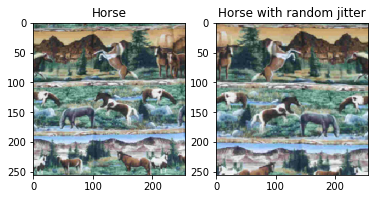

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

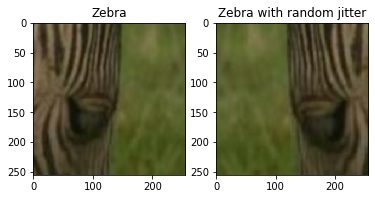

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Pix2Pix モデルをインポートしてサイズ変更する

インストールした [tensorflow_examples](https://github.com/tensorflow/examples) を介して [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) で使用したジェネレータとディスクリミネータをインポートします。

このチュートリアルで使用されるモデルアーキテクチャは、[pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) で使用されたものに非常によく似ていますが、以下のような違いがあります。

- Cyclegan は、[バッチ正規化](https://arxiv.org/abs/1502.03167)ではなく[インスタンス正規化](https://arxiv.org/abs/1607.08022)を使用します。
- [CycleGAN の論文](https://arxiv.org/abs/1703.10593)では、少し改良された `resnet`ベースのジェネレータが使用されています。このチュートリアルでは、簡単のため、少し改良された`unet` をジェネレータとして使用しています。

ここでトレーニングされるのは、以下のような 2 つのジェネレータ（G と F）と 2 つのディスクリミネータ（X と Y）です。

- ジェネレータ `G` は、画像 `X` を画像 `Y` に変換する方法を学習します。 $(G: X -> Y)$
- ジェネレータ `F` は、画像 `Y` を画像 `X` に変換する方法を学習します。$(F: Y -> X)$
- ディスクリミネータ `D_X` は、画像 `X` と生成された画像 `X`（`F(Y)`）を識別する方法を学習します。
- ディスクリミネータ `D_Y` は、画像 `Y` と生成された画像 `Y`（`G(X)`）を識別する方法を学習します。

![Cyclegan model](https://raw.githubusercontent.com/ko4ro/paper_survey_colab/main/asset/figures/cyclegan_model.png)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 損失関数

CycleGAN では、トレーニングできる対になったデータが存在しないため、トレーニング中の入力 `x` とターゲット `y` のペアに意味がある保証はありません。したがって、ネットワークによる的確なマッピングを強化するために、論文の執筆者は 周期的に一貫性のあるcycle consistency lossを提案しています。

ディスクリミネータ損失とジェネレータ損失は [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer) で使用されているものに似ています。

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

周期的な一貫性とは、結果が元の入力に近いことを指します。たとえば、ある文を英語からフランス語に翻訳してから、フランス語から英語に戻す場合、結果として得られる文は元の文と同じになるということです。

周期的一貫性を持つcycle consistency lossは、以下のように行われます。

- 画像 $X$ はジェネレータ $G$ を介して渡され、画像 $\hat{Y}$ を生成します。
- 生成された画像 $\hat{Y}$ はジェネレータ $F$ を介して渡され、周期後の画像 $\hat{X}$ を生成します。
- $X$ と $\hat{X}$ 間の平均絶対誤差が計算されます。

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$

![Cycle loss](https://raw.githubusercontent.com/ko4ro/paper_survey_colab/main/asset/figures/cycle_loss.png)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

上記に示す通り、画像 $X$ から画像 $Y$ への変換は、ジェネレータ $G$ が行います。 Identity lossは、画像 $Y$ をジェネレータ $G$ に与えた場合、実際の $Y$ または画像 $Y$ に似た画像を生成することを保証します。

例えて考えると、シマウマから馬への変換モデルを馬に、馬からシマウマへの変換モデルをシマウマに実行した場合、入力画像にはすでにターゲットクラスが含まれているので、画像はあまり変更されないはずです。

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$


In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

すべてのジェネレータとディスクリミネータのオプティマイザを初期化します。

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## チェックポイント

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## トレーニング

**注意:** このサンプルモデルは、このチュートリアルのトレーニング時間を合理的にするために、論文（200 回）よりも少ないエポック数（40）でトレーニングされています。そのため、予測の精度が減少する可能性があります。 

In [ ]:
EPOCHS = 40

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

トレーニングループは複雑に見えるかもしれませんが、以下の 4 つの基本ループで構成されています。

- 予測値を取得する。
- 損失を計算する。
- バックプロパゲーションして勾配を計算する。
- 勾配をオプティマイザに適用する。

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -&gt; Y
    # Generator F translates Y -&gt; X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## テストデータセットを使用して生成する

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## 次のステップ

このチュートリアルでは、[Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) チュートリアルで実装されたジェネレータとディスクリミネータを使って CycleGAN を実装する方法を紹介しました。次のステップとして、[TensorFlow データセット](https://www.tensorflow.org/datasets/datasets#cycle_gan)の別のデータセットを使用して試してみてください。

また、エポック数を増加してトレーニングし、結果がどのように改善されるか確認することもできます。さらに、ここで使用した U-Net ジェネレータの代わりに[論文](https://arxiv.org/abs/1703.10593)で使用されている変更された ResNet ジェネレータを実装してみるのもよいでしょう。

## Cycle GANをモバイル用モデルに変換
こちらのQiitaの[記事](https://qiita.com/john-rocky/items/3fbdb0892b639187c234)を参考に、CoreMLを利用してCycle GANをモバイル用モデルに変換に取り組みたいと思います。


In [ ]:
！pip install --upgrade tfcoreml

TFCoreMLをインストールします。

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

チェックポイントを復元します。

In [ ]:
generator_g.save（ './ savedmodel'）

saved_modelフォーマットでジェネレータg(horse2zebra）、ジェネレーターf（zebra2horse)を保存します。



In [ ]:
import tfcoreml
input_name = generator.inputs[0].name.split(':')[0]
print(input_name) #Check input_name.
keras_output_node_name = generator_g.outputs[0].name.split(':')[0]
graph_output_node_name = keras_output_node_name.split('/')[-1]
mlmodel = tfcoreml.convert('./savedmodel',
                       input_name_shape_dict={input_name: (1, 256, 256, 3)},
                       output_feature_names=[graph_output_node_name],
                       minimum_ios_deployment_target='13',
                       image_input_names=input_name,
                       image_scale=2/ 255.0,
                       red_bias=-1,
                       green_bias=-1,
                       blue_bias=-1,
                       )
mlmodel.save('./cyclegan.mlmodel')

TFCoreMLを用いて、モバイル用モデルに変換します。

In [ ]:
import Vision
lazy var coreMLRequest:VNCoreMLRequest = {
   let model = try! VNCoreMLModel(for: cyclegan().model)
   let request = VNCoreMLRequest(model: mode, completionHandler: self.coreMLCompletionHandler0)   
   return request
   }()

let handler = VNImageRequestHandler(ciImage: ciimage,options: [:])   

DispatchQueue.global(qos: .userInitiated).async {   
  try? handler.perform([coreMLRequest])
}

以上のセルを実行することにより、iOSプロジェクトでCycle GANを使用できます。



multiArrayを画像として視覚化するには、Hollance氏の[CoreML Helpers](https://github.com/hollance/CoreMLHelpers)が非常に便利です。

[MultiArrayからImageへの変換　CoreMLHelper
](https://qiita.com/john-rocky/items/bfa631aba3e7aabc2a66)
